# # Project: EuropeSoccer DataBase

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>  The EuropeSoccer Database contains data for soccer matches, players, and teams from several European countries from 2008 to
2016.

> The leagues matches recordeds on this database are:
>> Belgium Jupiler League;  
>>England Premier League;  
>>France Ligue 1;  
>>Germany 1;  
>>Bundesliga;  
>>Italy Serie A;  
>>Netherlands Eredivisie;  
>>Poland Ekstraklasa;  
>>Portugal Liga ZON Sagres;  
>>Scotland Premier League;  
>>Spain LIGA BBVA;  
>>Switzerland Super League;  


> Since the DataBase is provided as SQl.Lite,  I accessed the data using the DB Browser and conducted the following querie to collect the data that I need for my analysis:

>> SELECT match.id, country.name, league.name,  
match.season, match.stage, match.date, HomeTeam.team_long_name as home_team,  
AwayTeam.team_long_name as away_team, home_team_goal, away_team_goal,  
CASE WHEN home_team_goal >  away_team_goal THEN 'home win'  
WHEN home_team_goal = away_team_goal THEN 'draw'  
ELSE 'away win'  
END AS result  
FROM match  
INNER JOIN country ON  
match.country_id = country.id  
INNER JOIN league ON  
match.league_id = league.id  
INNER JOIN Team as HomeTeam ON    
match.home_team_api_id = HomeTeam.team_api_id  
INNER JOIN Team as AwayTeam ON   
match.away_team_api_id = AwayTeam.team_api_id  


> To perform this analysis, I focused on the match results and goals scored on the 11 Leagues, trying to understand:  
>> 1. which leagues are likely to occurs more goals?  
>>2. which clubs are top winners/scores?  
>>3. which results are more common? 
>>4. Are the total goals increasing by time?  
>>5. Wich month do the teams scores more goals?
>>6. which stages occur more goals?;



In [2]:
# importing packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import brewer2mpl

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling



### General Properties

In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('Soccer Database.csv')
print('Checking the DataFrame:')
df.head()

Checking the DataFrame:


,id,name,name.1,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,result
0,1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,KRC Genk,Beerschot AC,1,1,draw
1,2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,SV Zulte-Waregem,Sporting Lokeren,0,0,draw
2,3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,KSV Cercle Brugge,RSC Anderlecht,0,3,away win
3,4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,KAA Gent,RAEC Mons,5,0,home win
4,5,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,FCV Dender EH,Standard de Liège,1,3,away win


In [4]:
print('The shape of Dataframe is:', df.shape)

The shape of Dataframe is: (25979, 11)


In [5]:
print('The data types are:\n')
df.info()

The data types are:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              25979 non-null  int64 
 1   name            25979 non-null  object
 2   name.1          25979 non-null  object
 3   season          25979 non-null  object
 4   stage           25979 non-null  int64 
 5   date            25979 non-null  object
 6   home_team       25979 non-null  object
 7   away_team       25979 non-null  object
 8   home_team_goal  25979 non-null  int64 
 9   away_team_goal  25979 non-null  int64 
 10  result          25979 non-null  object
dtypes: int64(4), object(7)
memory usage: 2.2+ MB


In [6]:
print('Checking if there is any nullvalue...\nTotal of null values per column:')
df.isnull().sum()

Checking if there is any nullvalue...
Total of null values per column:


id                0
name              0
name.1            0
season            0
stage             0
date              0
home_team         0
away_team         0
home_team_goal    0
away_team_goal    0
result            0
dtype: int64

In [7]:
print('Checking if there is duplicated data...\n Total of duplicates:',sum(df.duplicated()))


Checking if there is duplicated data...
 Total of duplicates: 0




### Data Cleaning 

In [8]:
##change the column "name.1" name to league name
df.rename(columns={'name.1': 'league'}, inplace=True)



In [9]:
df_belgium = df[df['league']=='Belgium Jupiler League']
belgium_data = df_belgium.groupby(['league'])['season'].value_counts()
belgium_data

league                  season   
Belgium Jupiler League  2008/2009    306
                        2010/2011    240
                        2011/2012    240
                        2012/2013    240
                        2014/2015    240
                        2015/2016    240
                        2009/2010    210
                        2013/2014     12
Name: season, dtype: int64

In [10]:
#since belgium data for 2013/2014 season is missing and in order to preserve a solid base of comparison , 
#i decided to drop belgium record
index_names = df[df['league']=='Belgium Jupiler League'].index
#drop rows indexes for which column league has belgium league value
df.drop(index_names,inplace=True)

In [11]:
##create the column total_goals por match to perform futher analysis
df['total_goals'] = df['home_team_goal'] + df['away_team_goal']

In [12]:
#transform column date into datetime type
df['date']= pd.to_datetime(df['date'])
#create month column to perform futher analysis
df['month'] = df['date'].dt.month


<a id='eda'></a>
## Exploratory Data Analysis

### Which league score more Goals?

##### Spain Liga BBVA and England Premier League are the leagues with more goals recorded

In [13]:
#in order to easy the add color process, i created the function below. 
#it receives the quantity of different colours wanted and create the pallete
def color(qty):
    qty = qty
    bmap = brewer2mpl.get_map('Paired','qualitative',qty, reverse=True)
    colors = bmap.mpl_colors 
    return colors

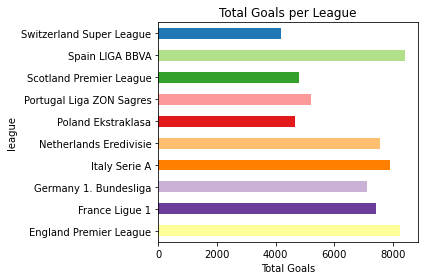

In [14]:
df.groupby(['league'])['total_goals'].sum().groupby(level=0).cumsum().plot(kind='barh', color=color(11))
plt.title('Total Goals per League')
plt.xlabel('Total Goals')
plt.tight_layout()
plt.show()



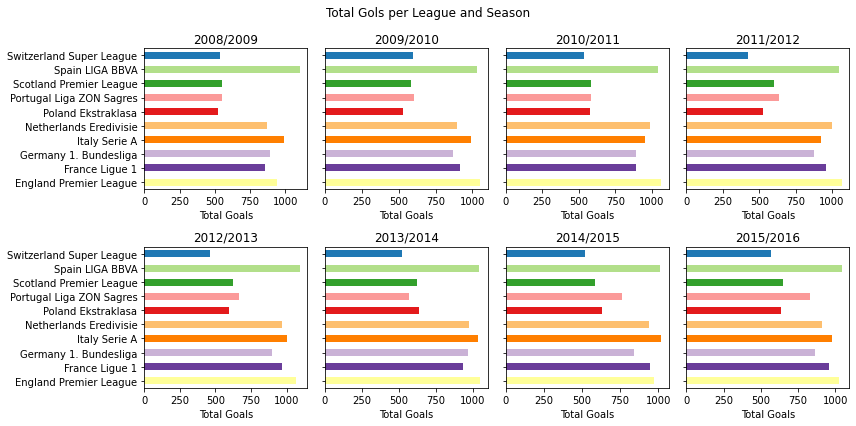

In [15]:
grouped = df.groupby(['season', 'league'])['total_goals'].sum().groupby(level=0)
ncols=4
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,6), sharey=True)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(kind='barh', ax=ax, color=color(11)) 
    ax.set_xlabel('Total Goals')
    ax.set_ylabel('')   
    ax.set_title(label=key)
    labels = [str(x) for x in df['league'].unique()]
    ax.set_yticklabels(labels)
     
fig.suptitle('Total Gols per League and Season')

plt.tight_layout()
plt.show()

###### In the last 8 seasons, Spain Liga BBVA has been the league with most goals scored.

### Which Teams have Scores More Goals?

###### Spain BBVA League and England Premier League are the two leagues with more goals scored. And, as you can see below, they are the leagues with more teams in the Overall Top scores

###### Spain BBVA is the league with most goals scored, and also it has the top two teams in the overall top scores

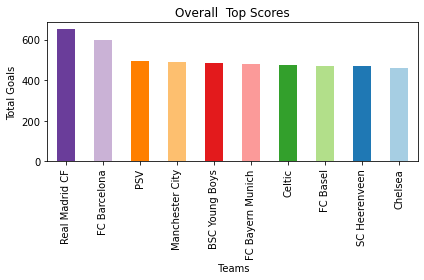

In [16]:

top_scores = df.groupby(['home_team'])['total_goals'].sum()
top_scores =top_scores.sort_values(ascending=False).head(10)
top_scores.plot(kind='bar', color = color(10))
plt.title('Overall  Top Scores')
plt.ylabel('Total Goals')
plt.xlabel(' Teams')
plt.tight_layout()
plt.show()



### Are teams that score more goals likely to win more games?
###### Not always. Juventus, FC Porto, SL Benfica and FC Basel aren't in the top 10 scores but they are among the top 10 winners

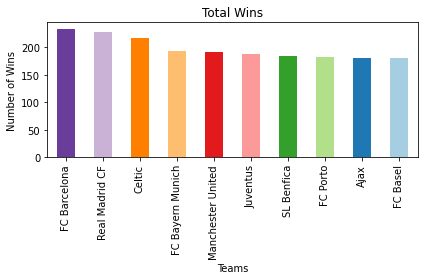

In [17]:
home_wins = pd.DataFrame(df.loc[df['result'] == 'home win', 'home_team'].value_counts().reset_index().values, columns=["team", "number_of_wins"])
home_wins = home_wins.sort_index(axis = 0, ascending=True)
away_wins = pd.DataFrame(df.loc[df['result'] == 'away win', 'away_team'].value_counts().reset_index().values, columns=["team", "number_of_wins"])
away_wins = away_wins.sort_index(axis = 0, ascending=True)
wins = pd.merge(home_wins, away_wins, on='team')
wins['number_of_wins'] = wins['number_of_wins_x'] + wins['number_of_wins_y']
wins.drop(['number_of_wins_x', 'number_of_wins_y'], axis=1, inplace=True)
total_wins = wins.sort_values(by=['number_of_wins'], ascending=False).head(10)

total_wins
total_wins.plot(kind='bar', color=color(10), x='team', y='number_of_wins', legend=False)
plt.title('Total Wins')
plt.xlabel('Teams')
plt.ylabel('Number of Wins')
plt.tight_layout()
plt.show()

### Results by League. In which league the away teams perform better?

##### The home teams have a great advantage over the away teams. but in the France ligue 1, Italy Serie A and Poland Ekstraklasa the visitors have better results

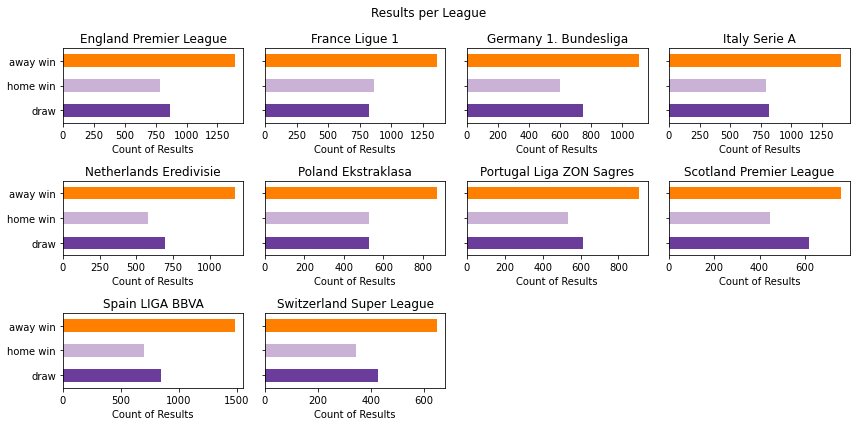

In [18]:
grouped = df.groupby(['league','result'])['result'].value_counts().groupby(level=0)
ncols=4
nrows = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,6), sharey=True)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(kind='barh', ax=ax, color=color(10), legend=False) 
    ax.set_xlabel('Count of Results')
    ax.set_ylabel('')   
    ax.set_title(label=key)
    labels = [str(x) for x in df['result'].unique()]
    ax.set_yticklabels(labels)
   
     
fig.suptitle('Results per League')
axes[-1, -1].axis('off')
axes[-1, -2].axis('off')
plt.tight_layout()
plt.show()

 ### Are the total goals increasing by time?

###### The total goals are increasing over time

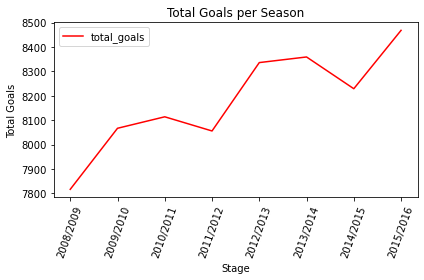

In [19]:
season_goals = df.groupby(['season']).agg({'total_goals':sum}).plot(color='r')
plt.title('Total Goals per Season')
plt.xlabel('Stage')
plt.ylabel('Total Goals')
plt.legend()
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

### Which month the teams scores more goals?

###### The season starts in the end of july. We can see that the goals tends to increase in the second half of the season

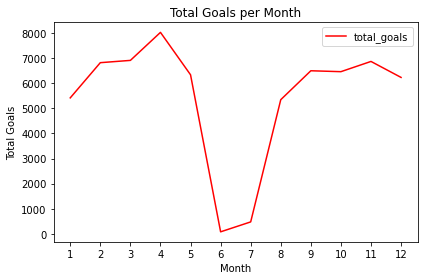

In [20]:
month_goals = df.groupby(['month']).agg({'total_goals':sum}).reset_index()
month_goals.plot(x='month', y='total_goals', color='r')
plt.title('Total Goals per Month')
plt.xlabel('Month')
plt.ylabel('Total Goals')
plt.legend()
label = [x for x in month_goals['month']]
plt.xticks(label)
plt.tight_layout()
plt.show()

##### PS: June and July are the ending of leagues seasons

### In the final stages do teams score more or less goals?

###### in the ending stages the teams tends to score fewer goals

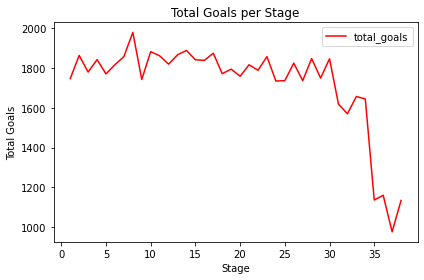

In [21]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.

stage_goals =df.groupby(['stage']).agg({'total_goals':sum}).plot(color ='r')
plt.title('Total Goals per Stage')
plt.xlabel('Stage')
plt.ylabel('Total Goals')
plt.legend()
plt.tight_layout()
plt.show()

<a id='conclusions'></a>
## Conclusions

> Spain's League and the England's Premier League are considered by many to be the two best soccers leagues in the world. Looking through the data we can see that these two leagues are the leagues with most goals scored.   


> Spain's BBVA goals record can be attributed to the performance of Real Madrid and Barcelona. These teams have scored around 600 goals each one, beating by at least 100 goals any  team from any other league.


>Although they are not teams that score many goals, Juventus, Benfica, Porto, Ajax and Basel are dominants in their domestic leagues, so they have a solid wins records.

>  The Away Teams from France Ligue 1, Poland Ekstraklasa and Italy Serie A performs better than the others


> the goals records are incresing by time, teams tends to score more goals in the second half of the seasons

>  In the final stages there are two types of matchs:
 >>1. the decisve ones;
 >>2. the nobody is losing any sleep over ones 
 
 
> in the both types due to the tension or the lack of interest the teams tends to score less goals


## Limitations
> This project focused on the avaible data:  match results and goals scored. Another variables such as weather, players, attendance etc may interfere in the match results/ goals scored.

> for example, to understand why the goals scored are increasing over time it's important to know if the players attributes are improving too: are there more players now who are better at shooting than in the past?

> or to understand why away teams in certain leagues performs better than others, it's interesting to analyze whether in these leagues home attendance is lower and if this impacts the performance of visiting teams
